# Generating handwritten digits
### We will implement a GAN that learns to produce realistic-looking handwritten digits. We will use the Python neural network library Keras with a TensorFlow backend.

### Importing modules and specifying model input dimensions

In [1]:
# import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# specifying model input dimensions
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels) # Input image dimensions
z_dim = 100 # Size of the noise vector, used as input to the Generator

### Implementing the Generator

In [3]:
# Generator
def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim)) # Fully connected layer
  model.add(LeakyReLU(alpha=0.01)) # Leaky ReLU activation
  model.add(Dense(28 * 28 * 1, activation='tanh')) # Output layer with tanh activation
  model.add(Reshape(img_shape)) # Reshapes the Generator output to image dimensions
  return model

### Implementing the Discriminator

In [4]:
# Discriminator
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape)) # Flattens the input image
  model.add(Dense(128)) # Fully connected layer
  model.add(LeakyReLU(alpha=0.01)) # Leaky ReLU activation
  model.add(Dense(1, activation='sigmoid')) # Output layer with sigmoid activation
  return model

### Building the model

In [5]:
# Building and compiling the GAN
def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)     # Combined Generator + Discriminator model
  model.add(discriminator)
  return model

# Builds and compiles the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Builds the Generator
generator = build_generator(img_shape, z_dim)

# Keeps Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Builds and compiles GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

### Training

In [6]:
# GAN training loop
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  #Loads the MNIST dataset
  (X_train, _), (_, _) = mnist.load_data()

  # Rescales [0, 255] grayscale pixel values to [–1, 1]
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all 1s
  real = np.ones((batch_size, 1))

  #Labels for fake images: all 0s 
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    #Gets a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Trains the Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Generates a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Trains the Generator
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:
      # Saves losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Outputs training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Outputs a sample of generated images
      sample_images(generator)


### Outputting sample images

In [7]:
# Displaying generated images
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generates images from random noise
  gen_imgs = generator.predict(z)

  # Rescales image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Sets image grid
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4, 4),
                          sharey=True,
                          sharex=True)
  
  # Outputs a grid of images 
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

### Running the model

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.073803, acc.: 98.83%] [G loss: 3.642577]
2000 [D loss: 0.190698, acc.: 93.36%] [G loss: 5.598251]
3000 [D loss: 0.033244, acc.: 99.61%] [G loss: 5.535235]
4000 [D loss: 0.272389, acc.: 90.62%] [G loss: 5.194855]
5000 [D loss: 0.229559, acc.: 92.19%] [G loss: 4.793144]
6000 [D loss: 0.226450, acc.: 91.02%] [G loss: 5.371436]
7000 [D loss: 0.369677, acc.: 85.55%] [G loss: 3.827341]
8000 [D loss: 0.322161, acc.: 86.72%] [G loss: 3.132048]
9000 [D loss: 0.163998, acc.: 93.75%] [G loss: 4.091448]
10000 [D loss: 0.461067, acc.: 80.08%] [G loss: 2.865821]
11000 [D loss: 0.529836, acc.: 76.95%] [G loss: 2.759457]
12000 [D loss: 0.553656, acc.: 76.17%] [G loss: 2.882021]
13000 [D loss: 0.353673, acc.: 85.16%] [G loss: 2.963434]
14000 [D loss: 0.670128, acc.: 71.09%] [G loss: 2.233589]
15000 [D loss: 0.402983, acc.: 80.47%] [G loss: 2.890560]
16000 [D loss: 0.570437, acc.: 71.88%] [G loss: 2.273135]
17000 [D loss: 0

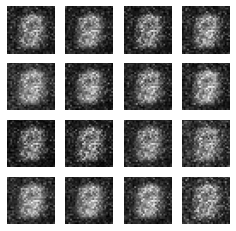

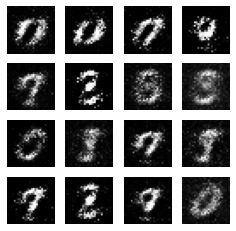

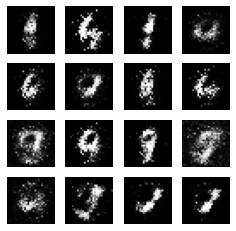

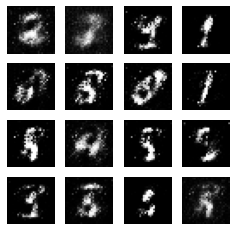

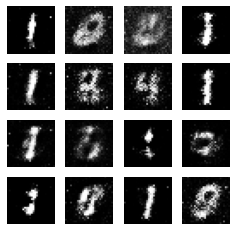

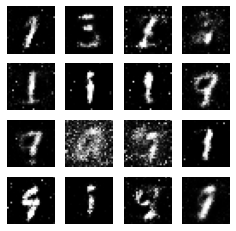

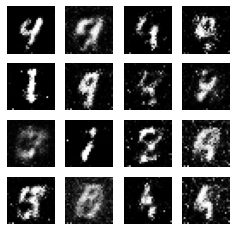

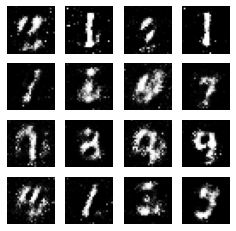

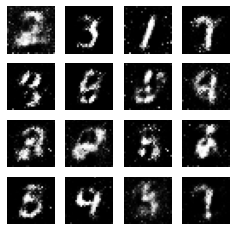

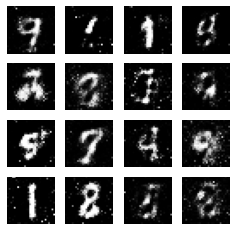

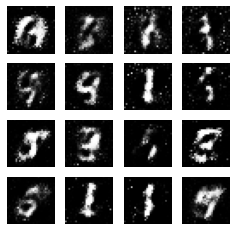

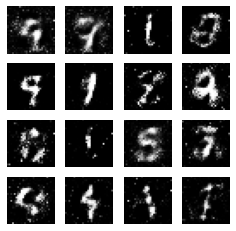

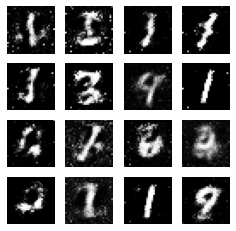

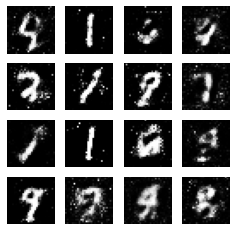

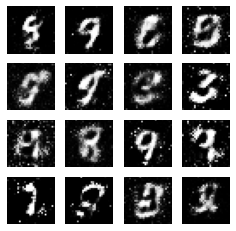

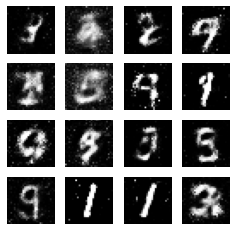

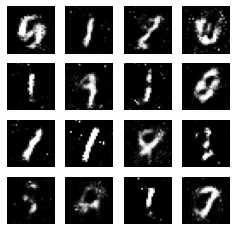

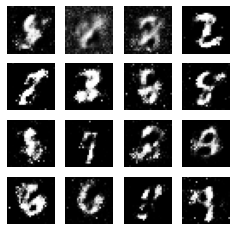

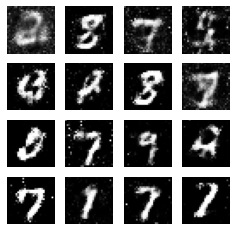

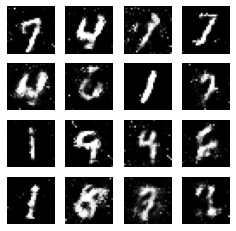

In [8]:
# Running the model
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Trains the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

## Conclusion
Although the images that GAN generated are far from perfect, many of them are easily recognizable as real numerals—an impressive achievement by using only a simple two-layer network architecture for both the Generator and the Discriminator. The quality of the generated images can be improved by using a more complex and powerful neural network architecture for the Generator and Discriminator such as convolutional neural networks.

# **Summary**
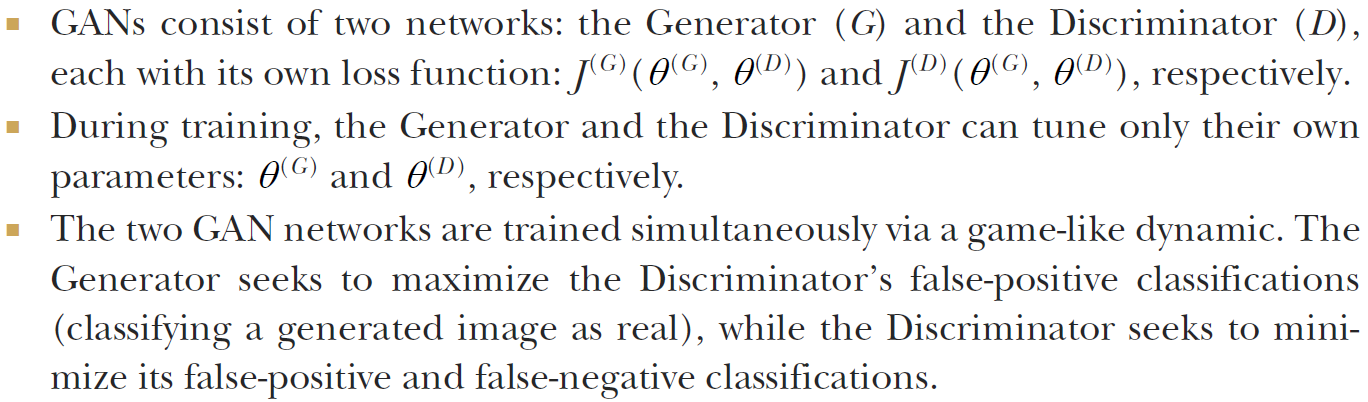